## Importing Libraries and Data

In [ ]:
#general imports
import os
import tensorflow as tf
import numpy as np
import json

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

#imports for the management of the dataset
from sklearn.model_selection import train_test_split
import cv2
#import for data augmentation
from keras.preprocessing.image import ImageDataGenerator
#imports for the display of the images and labels of the dataset
import time
from time import sleep
from matplotlib import cm
import matplotlib.pyplot as plt
#imports for the display of images of the test and the prediction
import tensorflow.compat.v2 as tf_v2
from PIL import Image
#imports for the realization of the model 
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.merge import add #?
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import LeakyReLU

# Set the seed for random operations in order to let the experiment be reproducible
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [ ]:
# Cell necessary when working on Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell in which it unzips given the directory
!unzip -n 'drive/My Drive/DeepLearning/Data/Development_Dataset.zip'

# Processing and organization of the dataset





In [ ]:
train_dir = os.path.join(cwd, 'Development_Dataset/Training')
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
filenames = []

for team in teams:
  filenames += os.listdir(train_dir + '/' + team + "/Haricot/Images")
  filenames += os.listdir(train_dir + '/' + team + "/Mais/Images")

print(filenames)
print("Training data:", len(filenames))

['Bipbip_haricot_im_02351.jpg', 'Bipbip_haricot_im_00651.jpg', 'Bipbip_haricot_im_06151.jpg', 'Bipbip_haricot_im_05111.jpg', 'Bipbip_haricot_im_01451.jpg', 'Bipbip_haricot_im_01631.jpg', 'Bipbip_haricot_im_08071.jpg', 'Bipbip_haricot_im_07861.jpg', 'Bipbip_haricot_im_03281.jpg', 'Bipbip_haricot_im_03231.jpg', 'Bipbip_haricot_im_03411.jpg', 'Bipbip_haricot_im_02171.jpg', 'Bipbip_haricot_im_03481.jpg', 'Bipbip_haricot_im_05351.jpg', 'Bipbip_haricot_im_01731.jpg', 'Bipbip_haricot_im_00451.jpg', 'Bipbip_haricot_im_05041.jpg', 'Bipbip_haricot_im_03041.jpg', 'Bipbip_haricot_im_06641.jpg', 'Bipbip_haricot_im_00321.jpg', 'Bipbip_haricot_im_03961.jpg', 'Bipbip_haricot_im_04791.jpg', 'Bipbip_haricot_im_05481.jpg', 'Bipbip_haricot_im_01091.jpg', 'Bipbip_haricot_im_00871.jpg', 'Bipbip_haricot_im_04401.jpg', 'Bipbip_haricot_im_08371.jpg', 'Bipbip_haricot_im_04031.jpg', 'Bipbip_haricot_im_02651.jpg', 'Bipbip_haricot_im_04591.jpg', 'Bipbip_haricot_im_06341.jpg', 'Bipbip_haricot_im_03291.jpg', 'Bipbip

In [ ]:
# remove extension from filenames
filenames = [string[:-4] for string in filenames]

In [ ]:
filenames_train, filenames_val = train_test_split(filenames,
                                                  test_size=.2,
                                                  shuffle=True,
                                                  random_state=1234)

print("Training data (after split):", len(filenames_train))
print("Validation data:", len(filenames_val))

Training data (after split): 576
Validation data: 144


In [ ]:
# cwd = os.getcwd()
dl_dir = '/content/drive/My Drive/DeepLearning/'
splits_dir = os.path.join(dl_dir, 'Splits')

if not os.path.exists(splits_dir):
    os.makedirs(splits_dir)

In [ ]:
train_txt = splits_dir + '/train.txt'
val_txt = splits_dir + '/val.txt'

with open(train_txt, 'w') as f:
  for x in filenames_train: 
    f.write(x + '\n')

with open(val_txt, 'w') as f:
  for x in filenames_val: 
    f.write(x + '\n')

## Creation of Generators and of CustomDataset object

In [ ]:
# ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10, ###aggiungi rescale?
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      rescale=1./255,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator(rescale=1./255)
    mask_data_gen = ImageDataGenerator()

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale=1./255)
valid_mask_data_gen = ImageDataGenerator()

In [ ]:
#Support function
def read_rgb_mask(mask_arr):
    #img_path: path to the mask file
    #Returns the numpy array containing target values
    
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [ ]:
#Support function
def parse_image_name(filename):
  names = filename.split('_')
  return names[0], names[1].capitalize()

In [ ]:
# CustomDataset inheriting from tf.keras.utils.Sequence
#the custom dataset returns a single sample from the dataset. Then, we use a tf.data.Dataset object to group samples into batches.
class CustomDataset(tf.keras.utils.Sequence):

  # Constructor
  def __init__(self, dl_dir, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=(2048, 2048)):
    if which_subset == 'training':
      subset_file = os.path.join(dl_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dl_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  # Returns the total number of samples in the dataset
  def __len__(self):
    return len(self.subset_filenames)


  # Returns a sample from the dataset after processing it
  def __getitem__(self, index):
    
    curr_filename = self.subset_filenames[index]

    team, plant = parse_image_name(curr_filename)
    img_path = self.dataset_dir + '/' + team + '/' + plant
    
    if(team == 'Roseau'):
      img_extension = '.png'
    else:
      img_extension = '.jpg'

    # Image processing and resizing
    img = cv2.imread(os.path.join(img_path, 'Images', curr_filename + img_extension), cv2.IMREAD_UNCHANGED) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_img = cv2.imread(os.path.join(img_path, 'Masks', curr_filename + '.png'), cv2.IMREAD_UNCHANGED)
    mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
    mask_img = cv2.resize(mask_img, self.out_shape, interpolation = cv2.INTER_AREA) 
    mask_arr = np.array(mask_img)
    # apply support function declared above
    mask_arr = read_rgb_mask(mask_arr)
    img = cv2.resize(img, self.out_shape, interpolation = cv2.INTER_AREA) 
    img_arr = np.array(img) 
    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training' or self.which_subset == 'validation':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        transformation = self.img_generator.get_random_transform(img_arr.shape)
        
        img_arr = self.img_generator.apply_transform(img_arr, transformation)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, transformation)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from keras.applications.resnet import preprocess_input

img_h = 2048
img_w = 2048

#Creation of CustomDataset objects for training and validation datasets
dataset = CustomDataset(dl_dir, train_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dl_dir, train_dir, 'validation', 
                              img_generator=valid_img_data_gen, mask_generator=valid_mask_data_gen,
                              preprocessing_function=preprocess_input)

In [ ]:
#Training
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1])
                                               )

train_dataset = train_dataset.batch(1)

train_dataset = train_dataset.repeat()

#Validation
valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1])
                                               )
valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

In [ ]:
#Here it is possible to test the augmentation and visualize it 
%matplotlib inline

# Assign a color to each class
colors = [[255,255,255],[216,67,82]]

iterator = iter(valid_dataset) #This can be changed to train_dataset

[0. 1. 2.]
(2048, 2048) (2048, 2048, 3)


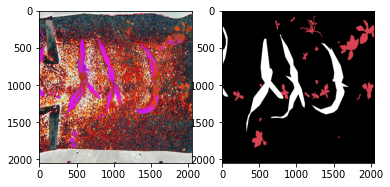

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element

target = np.array(target[0, ..., 0])

print(np.unique(target))
target_img = np.zeros([target.shape[0], target.shape[1], 3])

print(target.shape, target_img.shape)
target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Building the model
### Encoder: Transfer Learning from Resnet152

In [ ]:
#ResnNet152 is the pretrained model used as encoder of the model
res = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, classes=3, input_shape=(img_h, img_w, 3))
for layer in res.layers:
  layer.trainable = False

#for layer in res.layers[:-593]:
#    layer.trainable = True 
res.summary()

234700800/234698864 [==============================] - 1s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 2048,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 2054, 2054, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 1024, 1024, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 1024, 1024, 6 256         conv1_conv[0][0]                 
_______________________

### Decoder

In [ ]:
def add_decoder(model, depth, start_f, num_classes):
        
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(LeakyReLU(alpha=0.1)) #leaky relu instead of relu 

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))

In [ ]:
model = tf.keras.Sequential()

# add encoder to model
model.add(res) #previously we also used vgg16 but with lower results

add_decoder(model, depth=5, 
                     start_f=256, 
                     num_classes=3)

# Visualize created model as a table
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 64, 64, 2048)      58370944  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 2048)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 256)     4718848   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 256)     0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 256, 256, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     295040    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 128)     0

## Hyperparameters and Training of the model

In [ ]:
# Optimization params

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 5e-5 
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)
    per_class_iou = []
    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
cwd = os.getcwd()
callbacks = []

#Early stopping was applied and also a LR adapter callback,
# which helps us to get into the right minimum. 
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=3)
    callbacks.append(es_callback)
    
#LRPlateau
lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_meanIoU",
    factor=0.2,
    patience=2,
    min_lr=0,
)    

callbacks.append(lr_plateau_callback)

###TRAINING###
model.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid),
          callbacks = callbacks
          )

Epoch 1/10
576/576 [==============================] - 1840s 3s/step - loss: 0.1474 - accuracy: 0.9467 - meanIoU: 0.3515 - val_loss: 0.0885 - val_accuracy: 0.9655 - val_meanIoU: 0.4557
Epoch 2/10
576/576 [==============================] - 1816s 3s/step - loss: 0.0857 - accuracy: 0.9665 - meanIoU: 0.4852 - val_loss: 0.0889 - val_accuracy: 0.9656 - val_meanIoU: 0.4612
Epoch 3/10
576/576 [==============================] - 1811s 3s/step - loss: 0.0824 - accuracy: 0.9676 - meanIoU: 0.5027 - val_loss: 0.0811 - val_accuracy: 0.9690 - val_meanIoU: 0.4892
Epoch 4/10
576/576 [==============================] - 1811s 3s/step - loss: 0.0766 - accuracy: 0.9696 - meanIoU: 0.5247 - val_loss: 0.0727 - val_accuracy: 0.9719 - val_meanIoU: 0.5404


## Testing

*This section includes all the functions required for the realization of the predictions, a visualization of the prediction generated by the trained model and the creation of the json file for the submission*

In [ ]:
# Let's visualize the predictions done by the trained model
%matplotlib inline
iterator = iter(valid_dataset) 

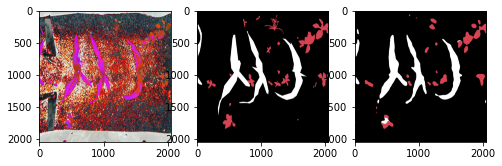

In [ ]:
colors = [[255,255,255],[216,67,82]]

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))
predicted_class = tf.argmax(out_sigmoid, -1)

predicted_class = predicted_class[0, ...]
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] 

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] 

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw();
#time.sleep(1)

In [ ]:
#Here, given the img name as input, the prediction is created
def create_mask_prediction(img_name):

  image = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)

  shape = image.shape
  image_array = cv2.resize(image, (img_w, img_h), interpolation = cv2.INTER_AREA)
  prediction = model.predict(tf.expand_dims(image_array, axis=0))
  prediction = tf_v2.image.resize(prediction, (shape[0], shape[1]), method='bicubic', antialias=True ) ##upscaling to original img size with bicubic interpolation method
  mask_arr = tf.argmax(prediction, -1)[0, ...]

  mask_arr = np.array(mask_arr)
  return mask_arr

In [ ]:
#Support function for the encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
#Support function for the correct addition of data to the submission file
def mask_arr_to_file(submission_dict, img_name, mask_arr):

  team_name , crop_name = parse_image_name(img_name)  

  img_name = img_name[:-4]

  #appends to json
  submission_dict[img_name] = {}
  submission_dict[img_name]['shape'] = mask_arr.shape
  submission_dict[img_name]['team'] = team_name
  submission_dict[img_name]['crop'] = crop_name
  submission_dict[img_name]['segmentation'] = {}

  rle_encoded_crop = rle_encode(mask_arr == 1)
  rle_encoded_weed = rle_encode(mask_arr == 2)
  #print("run",rle_encoded_crop) #for debugging
  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

In [ ]:
test_dir = os.path.join(cwd, 'Development_Dataset/Test_Dev/')
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
crops = ["Haricot" ,"Mais"]
filenames = []
submission_dict = {}

#Iteration on all images of both plant types of the four teams belonging to the test dataset
for team in teams:

  for crop in crops:

    filenames = os.listdir(test_dir + team + "/" + crop + "/Images")

    for img_name in filenames:

      path = os.path.join(test_dir, team + "/" + crop + "/Images/" + img_name)
      
      mask_arr = create_mask_prediction(path)
      #mask_arr = write_rgb_mask(mask_arr)
      #im = plt.imshow(mask_arr)
      #im.show()
      mask_arr_to_file(submission_dict, img_name, mask_arr)

In [ ]:
#Creation and saving of submission json file in Predictions directory
pred_dir = '/content/drive/My Drive/DeepLearning/Predictions'

if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

with open(pred_dir + '/submission.json', 'w') as f:
  json.dump(submission_dict, f)

In [ ]:
def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [ ]:
# Just for completeness, here we show how the rle encoded mask
# is transformed back to a numpy array, and the to images (some of them are displayed in the next cell)
test_dir = os.path.join(cwd, 'Development_Dataset/Test_Dev/')
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
crops = ["Haricot" ,"Mais"]

pred_dir = '/content/drive/My Drive/DeepLearning/Predictions' #directories which contains the submission file

with open(pred_dir + '/submission.json', 'r') as f:
    submission_dict = json.load(f)

for team in teams:

  for crop in crops:

    filenames = os.listdir(test_dir + team + "/" + crop + "/Images")

    for img_name in filenames:
      img_name = img_name[:-4]
      img_shape = submission_dict[img_name]['shape']

      rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
      rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

      # Reconstruct crop and weed binary masks
      crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
      weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

      # Reconstruct original mask
      # weed_mask * 2 allows to convert ones into target 2 (weed label)
      reconstructed_mask = crop_mask + (weed_mask * 2)

      # Just for visualisation purposes, save RGB reconstructed mask
      # Use again the dictionary in 'RGBtoTarget.txt'.
      reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
      reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
      reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

      reconstructed_rgb_img = Image.fromarray( np.uint8(reconstructed_rgb_arr))
      reconstructed_rgb_img.save('/content/drive/My Drive/DeepLearning/DecodingPred/res0.53/'+img_name+'.jpg') #path chosen for saving the images


**Let's visualize the predictions (one sample from each of the teams) on the test set done by the trained model.As implemented in the cell above,we took the encoded prediction from the submission file which was subsequently decoded and trasformed back to an image**  


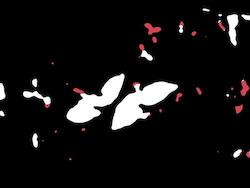 *BipBip team, haricot plant*
  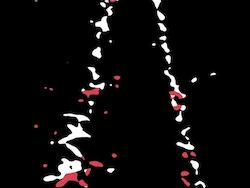 *Pead team, mais plant*
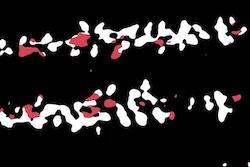 *Roseau team, haricot plant*
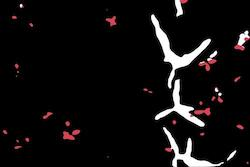 *Weedelec team, mais plant*